In [10]:
from UCLSE.dyna_q.Experiment1a import Experiment
from UCLSE.dyna_q.dyna_q import TabularMemory
from UCLSE.dyna_q.benchmarking import BenchmarkAgent, SpoofAgent, DoNothing
import numpy as np
import pandas as pd
import os
import torch
import visdom
import matplotlib.pyplot as plt

In [11]:
vis=visdom.Visdom(port=8097)

In [52]:
def reward_oracle(observation,cutoff=50,ub=6,lb=-2,lamb=0.5):


    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    bid_change=observation.bid_change
    bid_ask_spread=observation.bid_ask_spread
    time_left=observation.time_left

    ans=lamb*bid_change

    if inventory==0:   #terminal            
            
            ans+=-(1-lamb)*distance
            ans-=lamb*bid_change

    elif inventory>1: #terminal
            
            ans+=-bid_ask_spread*(inventory-1)
            ans+=-(1-lamb)*distance
           
    else:

            if orders_out>0: 
                ans+=1/250


            if time_left==1: #terminal takes account of exit spread
               
                ans+=-(1-lamb)*distance

            if -distance>=ub:
                
                ans+=-(1-lamb)*distance
              

            elif -distance<lb:
               
                ans+=-(1-lamb)*distance
               

    return ans 

def done_oracle(observation,cutoff=50,lb=-2,ub=6):

    distance=observation.distance
    inventory=observation.inventory
    orders_out=observation.orders_out
    time_left=observation.time_left

    if inventory==0:
        done=1
        why=f'inventory {inventory}=0'
    elif time_left>=1:
        done=1
        why=f'time up {time_left}'
    elif inventory>1:
        done=1
        why=f'inventory {inventory}>1'
    elif -distance>=ub:
        done=1
        why=f'-distance {distance} >ub {ub}'
    elif -distance<lb: 
        done=1
        why=f'-distance {distance}<lb {lb}'

    else:
        done=0 
        why=None
    return done,why


In [28]:
trader_pref_kwargs={'qty_min':-5,'qty_max':5,'sigma_pv':1}
timer_kwargs={'start':0,'end':6000,'step':1}
price_sequence_kwargs={'kappa':0.0002,'mean':100,'sigma':1,'block_length':10}
noise_kwargs={'sigma':1}
messenger_kwargs={'logging':True}
env_kwargs={'trader_arrival_rate':1,'recording':True,#'process_verbose':False,
                'bookkeep_verbose':False, 'lob_verbose':False}
sigma_n=5

def cont_coef():
    return np.random.uniform(0.2,0.8)

def personal_memory():
    return int(np.random.uniform(5,10))

trader_kwargs={'ZIP':{'prefix':'ZIP','number':10,'object_name':'WW_Zip',
                          'setup_kwargs':
                                {'market_make':True,'prior':(100,sigma_n)}},
               'HBL':{'prefix':'HBL','number':10,'object_name':'HBL',
                          'setup_kwargs':
                              {'memory':100,'grace_period':20}},
               'CON':{'prefix':'CON','number':10,'object_name':'ContTrader',
                      'setup_kwargs':
                          {'cont_coeff':cont_coef,'personal_memory':personal_memory,'profit_target':4, 'market_make':True,
                          'prior':(100,sigma_n)}},
               'NOI':{'prefix':'NOI','number':10,'object_name':'NoiseTrader',
                          'setup_kwargs':{'memory':20}}
              }

lobenv_kwargs={'cutoff':100,'profit_target':10,'loss_limit':-1,'reward_func':reward_oracle,'lamb':0.5}
agent_kwargs={'CVAE':False,'Q_H1Size':16,'Q_H2Size':16,
                   'doneModel':done_oracle,'rewardModel':reward_oracle,'loss_func':None}


In [29]:
dyna_config={
	"double_q_model": False,
	"batch_size": 64,
	"learning_rate": 5e-3,
	"exploration": {
		"type": "exponential",
		"init_epsilon": 0.8,
		"min_epsilon": 0.05,
		"decay_steps": 100000,
		"decay_eps": 0.99,
        "choice":'least_bonus'
	},
	"memory": {
		"memory_capacity": 1000000,
		"prioritized": False,
        "tabular memory":True,
        
	},
	"discount": 0.99,
	"target_update_freq": 50,
	"first_update": 200,
	"modify_reward": False,
    "learn":'Q',
    'double_q_model':True,
    'model_update_freq':5,
    'planning_freq':5,
    'model':'tabular'
    #"clipping":1
    
}

In [30]:
experiment=Experiment(trader_pref_kwargs=trader_pref_kwargs,timer_kwargs=timer_kwargs,
           price_sequence_kwargs=price_sequence_kwargs,noise_kwargs=noise_kwargs,
           messenger_kwargs=messenger_kwargs,env_kwargs=env_kwargs,trader_kwargs=trader_kwargs,
           lobenv_kwargs=lobenv_kwargs,agent_kwargs=agent_kwargs,visdom=vis,dyna_kwargs=dyna_config,name='Experiment_1b')

sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
setup tabular memory


In [31]:
experiment.new_train_setup(MaxEpisodes=1000,planning_steps=1,lookback=20,thresh=2,planning=True,graph=True)

In [33]:
experiment.resume(exp=experiment,best=True,folder='Results/'+experiment.name)

=> loading checkpoint 'Results/Experiment_1b\dyna_best.pth.tar'
=> loaded checkpoint 'Results/Experiment_1b\dyna_best.pth.tar' (epoch 9577)
keys unused in checkpoint data:  ['episode', 'setup']


In [25]:
experiment.recover_plots()

In [34]:
experiment.train(MaxEpisodes=10000,start_episode=experiment.episode,folder='Results/'+experiment.name)

Planning is True, double Q model is True, tabular memory is True
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 9581 | timestep: 2 | Ep_r:  1.004 Profit: 0 Avg loss:1.1685000000000003
Saving best checkpoint at episode 9585 with reward 1.2212
copying eval net to target net
Dyna-Q - EXP: 1 | Ep: 9601 | timestep: 11 | Ep_r:  2.54 Profit: 2 Avg loss:1.0514
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 9621 | timestep: 28 | Ep_r:  -0.6419999999999999 Profit: -4 Avg loss:0.6866000000000001
Dyna-Q - EXP: 1 | Ep: 9641 | timestep: 6 | Ep_r:  1.02 Profit: 0 Avg loss:0.6169
copying eval net to target net
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP: 1 | Ep: 9661 | timestep: 8 | Ep_r:  1.028 Profit: 0 Avg loss:0.5221
Dyna-Q - EXP: 1 | Ep: 9681 | timestep: 3 | Ep_r:  1.008 Profit: 0 Avg loss:0.4120000000000001
sequence made
adding exchange to

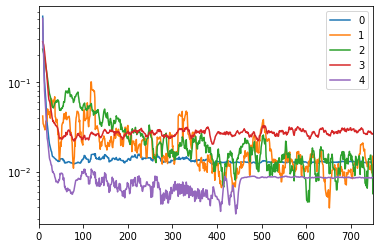

In [20]:
ax=pd.DataFrame(experiment.agent.env_losses).rolling(10).mean().plot()
ax.set_yscale('log')

In [36]:
experiment.agent.set_device('cpu')

Device in use is  cpu


In [37]:
experiment.test_setup(MaxEpisodes=5000)

sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Device in use is  cuda
setup tabular memory
Dyna-Q - EXP 1, | Ep: , 1, | timestep:  13 | Ep_r: -1.702|profit:-3 start:267|end:280
Dyna-Q - EXP 1, | Ep: , 11, | timestep:  16 | Ep_r: 1.06|profit:0 start:1914|end:1930
Dyna-Q - EXP 1, | Ep: , 21, | timestep:  3 | Ep_r: 1.008|profit:0 start:3332|end:3335
Dyna-Q - EXP 1, | Ep: , 31, | timestep:  5 | Ep_r: 2.016|profit:1 start:4732|end:4737
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 41, | timestep:  12 | Ep_r: 1.044|profit:0 start:716|end:728
r0 0.5
Dyna-Q - EXP 1, | Ep: , 51, | timestep:  18 | Ep_r: 1.068|profit:0 start:2249|end:2267
Dyna-Q - EXP 1, | Ep: , 61, | timestep:  2 | Ep_r: 1.004|profit:0 start:3631|end:3633
Dyna-Q - EXP 1, | Ep: , 71, | timestep:  7 | Ep_r: 1.024|profit:0 start:4876|end:4883
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q 

Dyna-Q - EXP 1, | Ep: , 691, | timestep:  100 | Ep_r: 0.9000000000000004|profit:-1 start:256|end:356
Dyna-Q - EXP 1, | Ep: , 701, | timestep:  100 | Ep_r: 0.9000000000000004|profit:-1 start:1634|end:1734
Dyna-Q - EXP 1, | Ep: , 711, | timestep:  11 | Ep_r: 1.04|profit:0 start:3112|end:3123
r0 0.5
Dyna-Q - EXP 1, | Ep: , 721, | timestep:  3 | Ep_r: 1.008|profit:0 start:4599|end:4602
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 731, | timestep:  9 | Ep_r: 1.032|profit:0 start:964|end:973
r0 0.5
Dyna-Q - EXP 1, | Ep: , 741, | timestep:  20 | Ep_r: 1.326|profit:1 start:2204|end:2224
r0 0.5
Dyna-Q - EXP 1, | Ep: , 751, | timestep:  27 | Ep_r: -0.3959999999999999|profit:-1 start:3527|end:3554
Dyna-Q - EXP 1, | Ep: , 761, | timestep:  11 | Ep_r: 2.04|profit:1 start:4801|end:4812
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 771, | timestep:  9 | Ep_r: 1.032|profit:0 start:936|e

Dyna-Q - EXP 1, | Ep: , 1391, | timestep:  12 | Ep_r: 1.044|profit:0 start:3481|end:3493
Dyna-Q - EXP 1, | Ep: , 1401, | timestep:  2 | Ep_r: 1.004|profit:0 start:4859|end:4861
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 1411, | timestep:  2 | Ep_r: 1.004|profit:0 start:1050|end:1052
Dyna-Q - EXP 1, | Ep: , 1421, | timestep:  11 | Ep_r: -1.71|profit:-3 start:2418|end:2429
Dyna-Q - EXP 1, | Ep: , 1431, | timestep:  2 | Ep_r: 1.004|profit:0 start:3891|end:3893
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 1441, | timestep:  29 | Ep_r: -0.3879999999999999|profit:-2 start:169|end:198
Dyna-Q - EXP 1, | Ep: , 1451, | timestep:  32 | Ep_r: 1.124|profit:0 start:1780|end:1812
r0 0.5
Dyna-Q - EXP 1, | Ep: , 1461, | timestep:  7 | Ep_r: 1.024|profit:0 start:3014|end:3021
Dyna-Q - EXP 1, | Ep: , 1471, | timestep:  4 | Ep_r: 1.012|profit:0 start:4447|end:4451
sequence made
ad

Dyna-Q - EXP 1, | Ep: , 2091, | timestep:  31 | Ep_r: 1.12|profit:0 start:3148|end:3179
Dyna-Q - EXP 1, | Ep: , 2101, | timestep:  2 | Ep_r: 1.004|profit:0 start:4923|end:4925
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2111, | timestep:  17 | Ep_r: 1.064|profit:0 start:1117|end:1134
Dyna-Q - EXP 1, | Ep: , 2121, | timestep:  20 | Ep_r: -0.6739999999999999|profit:-1 start:2554|end:2574
Dyna-Q - EXP 1, | Ep: , 2131, | timestep:  11 | Ep_r: 2.04|profit:1 start:4240|end:4251
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 2141, | timestep:  14 | Ep_r: 1.052|profit:0 start:672|end:686
Dyna-Q - EXP 1, | Ep: , 2151, | timestep:  52 | Ep_r: 1.2040000000000002|profit:0 start:1989|end:2041
Dyna-Q - EXP 1, | Ep: , 2161, | timestep:  48 | Ep_r: -0.31199999999999983|profit:-3 start:3316|end:3364
Dyna-Q - EXP 1, | Ep: , 2171, | timestep:  7 | Ep_r: 1.024|profit:0 start:4503|end

Dyna-Q - EXP 1, | Ep: , 2801, | timestep:  19 | Ep_r: 1.072|profit:0 start:4737|end:4756
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 2811, | timestep:  67 | Ep_r: 1.2640000000000002|profit:0 start:1071|end:1138
Dyna-Q - EXP 1, | Ep: , 2821, | timestep:  2 | Ep_r: 1.004|profit:0 start:2656|end:2658
Dyna-Q - EXP 1, | Ep: , 2831, | timestep:  11 | Ep_r: 1.04|profit:0 start:3917|end:3928
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2841, | timestep:  21 | Ep_r: 1.08|profit:0 start:279|end:300
Dyna-Q - EXP 1, | Ep: , 2851, | timestep:  16 | Ep_r: -0.43999999999999995|profit:-1 start:1465|end:1481
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2861, | timestep:  38 | Ep_r: -0.35199999999999987|profit:-1 start:2625|end:2663
r0 0.5
Dyna-Q - EXP 1, | Ep: , 2871, | timestep:  8 | Ep_r: 1.028|profit:0 start:4133|end:4141
r0 0.5
sequence made
adding exchange to RL trader  RL
adding exchang

Dyna-Q - EXP 1, | Ep: , 3491, | timestep:  66 | Ep_r: 1.2600000000000002|profit:0 start:824|end:890
Dyna-Q - EXP 1, | Ep: , 3501, | timestep:  3 | Ep_r: 2.008|profit:1 start:2165|end:2168
Dyna-Q - EXP 1, | Ep: , 3511, | timestep:  2 | Ep_r: 2.004|profit:1 start:3461|end:3463
Dyna-Q - EXP 1, | Ep: , 3521, | timestep:  57 | Ep_r: -0.2759999999999998|profit:-1 start:4704|end:4761
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 3531, | timestep:  10 | Ep_r: 1.036|profit:0 start:1261|end:1271
Dyna-Q - EXP 1, | Ep: , 3541, | timestep:  71 | Ep_r: 1.2800000000000002|profit:0 start:2670|end:2741
Dyna-Q - EXP 1, | Ep: , 3551, | timestep:  11 | Ep_r: 1.04|profit:0 start:4261|end:4272
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 3561, | timestep:  10 | Ep_r: -0.46399999999999997|profit:-3 start:408|end:418
Dyna-Q - EXP 1, | Ep: , 3571, | timestep:  7 | Ep_r: 1.024|profit:0 start:1713

Dyna-Q - EXP 1, | Ep: , 4191, | timestep:  7 | Ep_r: 2.024|profit:1 start:2994|end:3001
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4201, | timestep:  3 | Ep_r: 1.008|profit:0 start:4253|end:4256
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4211, | timestep:  48 | Ep_r: -1.5619999999999998|profit:0 start:498|end:546
Dyna-Q - EXP 1, | Ep: , 4221, | timestep:  2 | Ep_r: 2.004|profit:1 start:2018|end:2020
Dyna-Q - EXP 1, | Ep: , 4231, | timestep:  21 | Ep_r: -1.67|profit:-1 start:3722|end:3743
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4241, | timestep:  42 | Ep_r: -0.33599999999999985|profit:-1 start:5030|end:5072
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4251, | timestep:  42 | Ep_r: 1.1640000000000001|profit:0 start:1231|end:1273
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4261, | timestep:  3 | Ep_r: 1.008|profit:0 start:2630|end:2633
Dyna-Q - EXP 1, | Ep: , 4271, | timestep:  29 | Ep_r: -

Dyna-Q - EXP 1, | Ep: , 4891, | timestep:  42 | Ep_r: -0.33599999999999985|profit:-1 start:2078|end:2120
Dyna-Q - EXP 1, | Ep: , 4901, | timestep:  56 | Ep_r: 2.22|profit:1 start:3723|end:3779
r0 0.5
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 4911, | timestep:  8 | Ep_r: 1.028|profit:0 start:27|end:35
Dyna-Q - EXP 1, | Ep: , 4921, | timestep:  25 | Ep_r: 1.096|profit:0 start:1591|end:1616
Dyna-Q - EXP 1, | Ep: , 4931, | timestep:  37 | Ep_r: 1.1440000000000001|profit:0 start:3162|end:3199
Dyna-Q - EXP 1, | Ep: , 4941, | timestep:  23 | Ep_r: 1.088|profit:0 start:4580|end:4603
r0 1.0
sequence made
adding exchange to RL trader  RL
adding exchange to RL trader  RL
Dyna-Q - EXP 1, | Ep: , 4951, | timestep:  39 | Ep_r: -0.34799999999999986|profit:-3 start:688|end:727
r0 0.5
Dyna-Q - EXP 1, | Ep: , 4961, | timestep:  4 | Ep_r: 1.012|profit:0 start:1966|end:1970
Dyna-Q - EXP 1, | Ep: , 4971, | timestep:  4 | Ep_r: 1.012|profit:0 sta

(-10, 10)

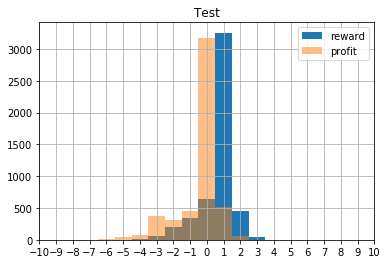

In [38]:
ax,d=experiment.plot_hist_profit()
ax.set_xlim(-10,10)

In [39]:
d.describe()

,0,1,2,3,4,5,6
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2508.750200,2528.268400,49496.93000,2499.500000,0.693386,-0.424800,0.096440
std,1489.380027,1489.169123,27912.78571,1443.520003,1.010639,1.230873,0.019683
min,15.000000,23.000000,13.00000,0.000000,-3.746000,-8.000000,-0.200000
25%,1202.000000,1226.500000,25261.75000,1249.750000,0.396000,-1.000000,0.100000
50%,2479.500000,2508.500000,49566.00000,2499.500000,1.028000,0.000000,0.100000
75%,3804.250000,3827.250000,73779.75000,3749.250000,1.080000,0.000000,0.100000
max,5324.000000,5355.000000,97591.00000,4999.000000,4.294000,4.000000,0.100000


In [42]:
def plotbm_results(experiment,title1,title2,ds=None,memory_s=None,name=None,path='Results/'):
    try:
        assert name is not None
    except AssertionError:
        print('specify folder name to save results in')
    path=os.path.join(path,name)
    
    Experiment.check_dir_exists_make_else(path)
    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1, figsize=(16, 16), dpi=80, facecolor='w', edgecolor='k')
    if ds is None: ds=pd.DataFrame(experiment.rwd_test)
    bins=np.arange(-10.5,10.5,1)
    ax1=ds[4].hist(ax=ax1,bins=bins,label='reward')
    ds[5].hist(bins=bins,label='profit',ax=ax1,alpha=0.5)
    ax1.legend()
    _=ax1.xaxis.set_ticks(np.arange(-10,11))
    ax1.set_title(title1)

    #format returns df
    ds['duration']=ds[1]-ds[0]
    ds=ds[[4,5,6,'duration']]
    ds.columns=['reward','profit','start distance','duration']

    #save returns df
    ds.to_csv(os.path.join(path,name+'_returns.csv'))


    obs_names=['distance','inventory','orders_out','bid_change','ask_change',
               'bid_ask_spread','position_in_lob','imbalance','time_left']
    columns=obs_names+['action','rw','done']+['n_'+o for o in obs_names]
    if memory_s is None: 
        memory_s=pd.DataFrame(experiment.agent_test.memory,columns=columns)
        memory_s=memory_s[:experiment.agent_test.memory_counter]
        memory_s.to_csv(os.path.join(path,name+'_memory.csv'))
    #memory_s.position_in_lob.value_counts(),memory_s.action.value_counts()
    memory_s.imbalance.hist(ax=ax2)
    ax2.set_title(title2)
    ax2.set_xlim(-1,1)

    fig.savefig(os.path.join(path,name+'_hist'))

    return ds,memory_s

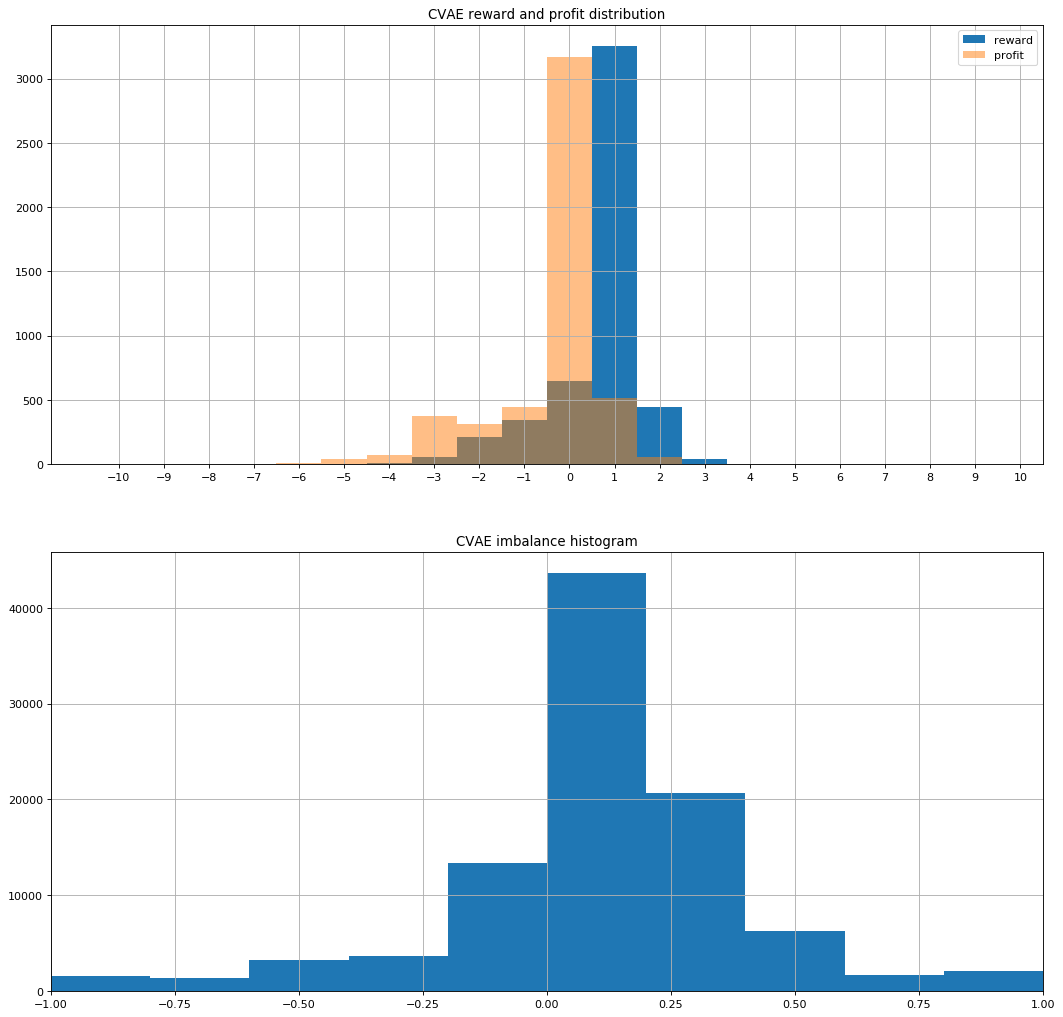

In [43]:
path='Results'
d,memory=plotbm_results(experiment,'CVAE reward and profit distribution',
                                   'CVAE imbalance histogram',name=experiment.name,path=path)

In [44]:
d.describe()

,reward,profit,start distance,duration
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.693386,-0.424800,0.096440,19.518200
std,1.010639,1.230873,0.019683,19.269144
min,-3.746000,-8.000000,-0.200000,1.000000
25%,0.396000,-1.000000,0.100000,7.000000
50%,1.028000,0.000000,0.100000,12.000000
75%,1.080000,0.000000,0.100000,26.000000
max,4.294000,4.000000,0.100000,100.000000


In [42]:
experiment.agent.env_losses

[]

In [45]:
memory.n_inventory.value_counts(), memory.action.value_counts()

(1.0    92622
 0.0     3730
 2.0     1239
 Name: n_inventory, dtype: int64, 2.0    65243
 0.0    16793
 3.0    10798
 4.0     4757
 Name: action, dtype: int64)

In [47]:
from UCLSE.dyna_q.Experiment1a import obs_names
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


def fit_tree(memory,path,experiment):

    x=memory[obs_names]
    y=memory['action']

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    clf = DecisionTreeClassifier(random_state=0,max_depth=3)
    clf.fit(X_train,y_train)


    class_labels=[(str(k),str(experiment.lobenv_test.new_action_dic[k])) for k in memory['action'].value_counts().index.sort_values()]
    class_labels=pd.DataFrame(class_labels)

    out_path=os.path.join(path,'tree.dot')
    im_path=os.path.join(path,'tree.png')
    
    from sklearn.tree import export_graphviz
    export_graphviz(clf, out_file=out_path, 
                    feature_names = obs_names,
                    class_names = class_labels[1],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    from subprocess import call
    call(['dot', '-Tpng', out_path, '-o', im_path, '-Gdpi=600'])

    # Display in jupyter notebook
    from IPython.display import Image
    
    
    Image(filename = im_path)
    
    train_score=clf.score(X_train,y_train)
    test_score=clf.score(X_test,y_test)
    importances=pd.DataFrame({'obs_name':obs_names,'importance':clf.feature_importances_})
    
    return clf,train_score,test_score,importances

In [51]:
clf,train_score,test_score,importances=fit_tree(memory,os.path.join('Results',experiment.name),experiment)